## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
# working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 813.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 27.1 MB/s eta 0:00:00


In [3]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


### 1.2 Imports

In [4]:
import os
import random

import albumentations as A
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from datasets import load_dataset
from livelossplot import PlotLosses
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)
# Local imports
import utils.data_handler as dh
import utils.mri_plotter as mrp
import utils.metrics as metrics

# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
# Todo: delete this when the functions are finalized
importlib.reload(dh)
importlib.reload(mrp)
importlib.reload(metrics)

from utils.data_handler import DataHandler, MriType, StructuralScan
from utils.mri_plotter import MRIPlotter
np.set_printoptions(precision=16)


### 1.3 Initializations (important!)

In [5]:
# this class will handle all actions related to saving and loading files
# by default, downloads files into the runtime but saves training data to the cloud
data_handler = DataHandler()

In [6]:
# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [7]:
# specify which training directory to use
train_dir_prefix = create_train_dir_by_date()
# train_dir_prefix = 'maskformer/huafeng'
# train_dir_prefix = maskformer/keith

# this part will check if the directory already exists and whether the person intends to overwrite the files in that director
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input("This directory has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer != "YES":
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

RETRAIN = False

This directory has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using training_dir_prefix: maskformer/huafeng


### 1.4 General functions

In [8]:
# helper functions
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

## get mask
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

def softmax(logits):
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def softmax_2d(logits):
    e_x = np.exp(logits - np.max(logits, axis=(0, 1), keepdims=True))
    return e_x / np.sum(e_x, axis=(0, 1), keepdims=True)

In [9]:
# Reusable functions
def get_subj_ids(subj_files):
    # get unique subj train ids: [0001, 0002, 0003 ..]
    subj_ids = []
    for subj in subj_files:
        subj_id = data_handler.get_mri_subj_id(subj)
        if subj_id not in subj_ids:
            subj_ids.append(subj_id)
    return subj_ids

def get_subset_files(subj_files, subj_ids):
    # filter files within range
    subj_filenames = []
    for file_name in subj_files:
        subj_id = data_handler.get_mri_subj_id(file_name)
        subj_idx = subj_ids.index(subj_id)
        file_no = data_handler.get_mri_file_no(file_name)
        if file_no >= file_no_min and file_no < file_no_max and subj_idx >= subj_id_min and subj_idx < subj_id_max:
            subj_filename = data_handler.get_mri_subj_file(file_name)
            # item has to be unique
            if subj_filename not in subj_filenames:
                subj_filenames.append(subj_filename)
    subj_filenames.sort()
    return subj_filenames


### 1.5 Data loaders
We define here how to organize data into the input format for maskformer

In [10]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, data_handler: DataHandler, dataset_type: MriType, data_list_fn, processor, transform=None, augment=None):
        """
        Args:
            dataset
        """
        # valid types: MriType.TRAIN_2D, MriType.VAL_2D, MriType.TRAIN_2d_CROSS and  MriType.VAL_2D_CROSS
        self.mri_type = dataset_type

        self.processor = processor
        self.transform = transform
        self.augment = augment

        # use the Data Handler class to handle all sorts of image loading
        self.data_handler = data_handler

        # read the text file and store in memory instead of reading every getitem call. not sure if there will be a problem
        self.data_list = self.data_handler.load_text_as_list(file_name = data_list_fn, train_dir_prefix=train_dir_prefix)
        self.n_data = len(self.data_list)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        # find a file corresponding to idx
        item = None
        try:
          item = self.data_list[idx]
        except IndexError:
          item = self.data_list[0]

        subj_no = item.split('.')[0].split('_')[0]
        file_no = item.split('.')[0].split('_')[1]
        # print("Subj no", subj_no)
        # print("File no", file_no)
        # load data file to image and instance_seg
        # return nifti=True to return format before converting to numpy get_fdata

        data_cur, data_cur_nifti = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type,
                                              struct_scan = StructuralScan.FLAIR, return_nifti=True)
        # print(data_cur.shape)
        n_h = data_cur_nifti.shape[0]
        n_w = data_cur_nifti.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        # convert data range from [0 1] to [0 255]
        image[:,:,0] = data_cur * 255
        # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1)
        image[:,:,1] = data_cur * 255

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1GD)
        image[:,:,2] = data_cur * 255

        # load segm file
        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, dtype="uint8")
        instance_seg =  np.zeros( (n_h, n_w), dtype='uint8')
        instance_seg[:,:] = data_cur
        # print(instance_seg.max())
        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        mapping_dict[4] = 3
        # mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply data augmentation
        if self.augment is True:

            # # Image Color Jittering
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())
            pil_image = Image.fromarray(image.astype(np.uint8))
            color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            pil_image = color_jitter(pil_image)
            image = np.array(pil_image)
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            # convert to tensors
            image = torch.from_numpy(image.astype('float'))
            instance_seg = torch.from_numpy(instance_seg)
            # print("image mean, max=",image[0,:,:].mean(), image[0,:,:].max())

            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.2:
                chance1 = random.choice([0,1,2,3,4])
                dim1 = image.shape
                # print('Original image dimension:',dim1,'choice:',chance1)
                if chance1 == 0: #upper left
                    image        =        image[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                elif chance1 == 1: #upper right
                    image        =        image[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image        =        image[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                elif chance1 == 3: #lower left
                    image        =        image[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                else: # center
                    image        =        image[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

        # apply input transforms, including resize (after cropping)
        if self.transform:
            transformed = self.transform(image=image, mask=instance_seg)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

            image, instance_seg = transformed['image'], transformed['mask']
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

        # Prepare data to fit Maskformer input
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs


## 2. Process 2D data

### 2.1 load and select data

In [11]:
# set directories
train_list_full = "data_train_all.txt"
val_list_full   = "data_val_all.txt"
train_list = "data_train.txt"
val_list   = "data_val.txt"

# old functionality
# ! ls $train_dir > $train_list_full
# ! ls $val_dir   > $val_list_full

#### Using below if use all data

In [12]:
# train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D_CROSS)
# train_files_unique = [data_handler.get_mri_subj_file(file_name) for file_name in train_2d]
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")
# data_handler.save_text(file_name = train_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in train_files_unique))


# val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D_CROSS)
# val_files_unique = [data_handler.get_mri_subj_file(file_name) for file_name in val_2d]
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")
# data_handler.save_text(file_name = val_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in val_files_unique))

#### **Testing:** Using a small portion of data for efficient testing

In [12]:
# list files
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# save as text file
data_handler.save_text(file_name = train_list_full,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_2d))
data_handler.save_text(file_name = val_list_full,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_2d))

100%|██████████| 913M/913M [00:09<00:00, 95.4MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 64241/64241 [00:14<00:00, 4479.13it/s]
100%|██████████| 322M/322M [00:03<00:00, 97.2MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 21901/21901 [00:05<00:00, 4367.59it/s]


In [13]:
# selecting slice range
n_total = 146
# file_no_min = n_total//2 - 20
# file_no_max = n_total//2 + 20
file_no_min = 0
file_no_max = n_total + 1

# selecting patent id range
subj_total = 88
# subj_id_min = 0
# subj_id_max = 1
subj_id_min = 0
subj_id_max = subj_total + 1

# Define train and validation dataset
# obtain all train subject ids
subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
                                                  train_dir_prefix=train_dir_prefix)
subj_train_ids = get_subj_ids(subj_train_files)

train_files_unique_c = get_subset_files(subj_train_files, subj_train_ids)
print(f"Number of unique training samples: {len(train_files_unique_c)}")
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_files_unique_c))

# do same for validation
subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
                                                train_dir_prefix=train_dir_prefix)

subj_val_ids = get_subj_ids(subj_val_files)
val_files_unique_c = get_subset_files(subj_val_files, subj_val_ids)
print(f"Number of unique validation samples: {len(val_files_unique_c)}")
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_files_unique_c))


Number of unique training samples: 12848
Number of unique validation samples: 4380


### 2.2 Create Custom PyTorch Dataset


In [14]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [15]:
# create train/validation datasets

# use the same mean and std as training set
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# define data transoforms
train_transform = A.Compose([
    # A.Resize(width=146, height=193),
    # A.Resize(width=193, height=163),
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# create datasets
train_dataset = CustomMRIDataset(data_handler=data_handler, dataset_type=MriType.TRAIN_2D, data_list_fn=train_list, processor=processor, transform=train_transform, augment=False)
val_dataset = CustomMRIDataset(data_handler=data_handler, dataset_type=MriType.VAL_2D, data_list_fn=val_list, processor=processor, transform=train_transform, augment=False)

In [16]:
# setup data loader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [17]:
# make label dictionary
id2label = dh.SEGMENTS

# replace the index 4 with 3
if 4 in id2label:
    id2label[3] = id2label[4]
    del id2label[4]

print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


### 2.3 QC dataset

In [18]:
# peek at the dataset

inputs = train_dataset[120]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
12848
tensor([0, 1, 2, 3])


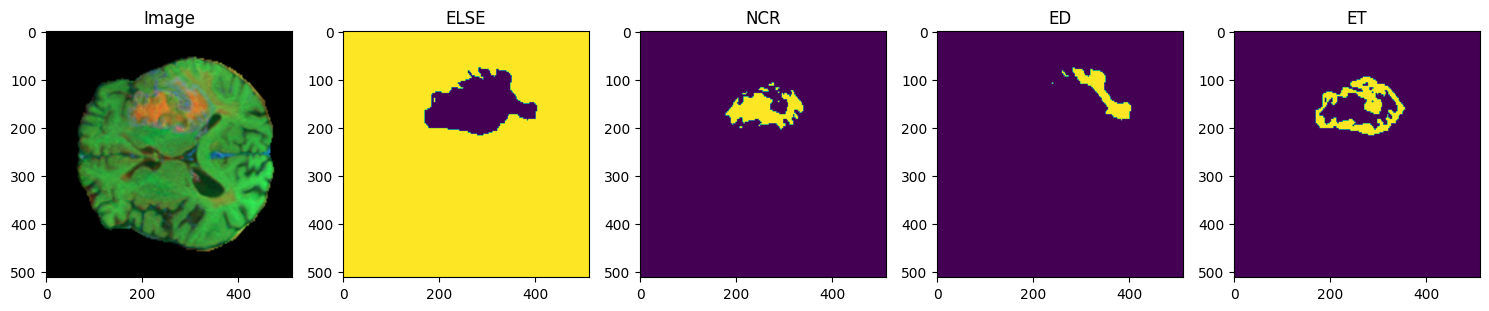

In [19]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"Image")

for mask_idx, mask in enumerate(inputs["class_labels"]):
    mask_value = mask.item()
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[mask_value]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

In [20]:
# peek at the dataset

inputs = val_dataset[120]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
4380
tensor([0, 1, 2, 3])


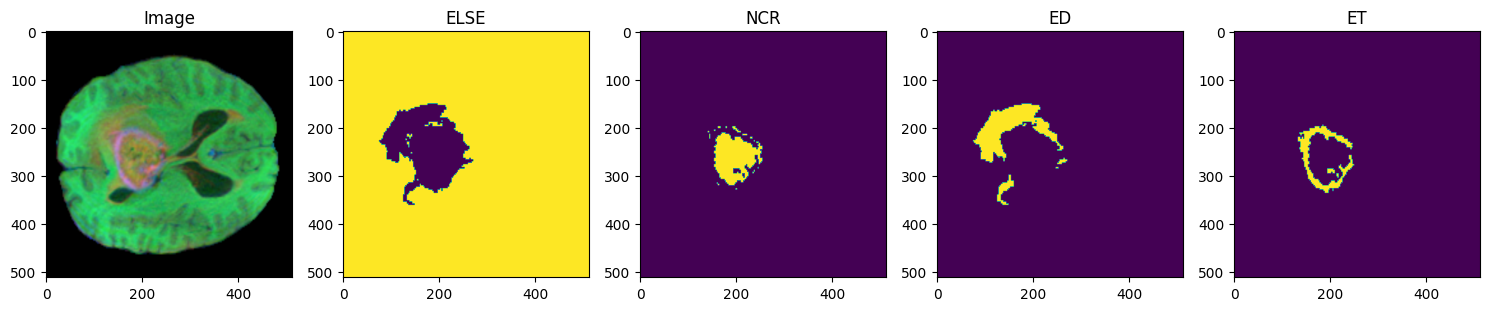

In [21]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"Image")

for mask_idx, id in enumerate(inputs["class_labels"]):
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[id.item()]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

## 3. Fine-tuning Model

### 3.1 Define the model

In [22]:
# load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# print model config
configuration = model.config
# print(configuration)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# load saved model if needed. will work even if file is locally saved in the /training dir
# model_stream = data_handler.load_from_stream(file_name="model_all_10epoch_better.pt", train_dir_prefix=train_dir_prefix)
# model = torch.load(model_stream)

In [24]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 512, 512]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 512, 512]     [2, 128, 128, 128]   86,882,424           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 128, 128, 128]   --                   4,951,808            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [ ]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print('Initial Loss is:',outputs.loss.item())


pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
class_labels 1
mask_labels 1
[torch.Size([4])]
[torch.Size([4, 512, 512])]
Initial Loss is: 3.704277992248535


### 3.3 Train the model

In [ ]:
# training
liveloss = PlotLosses()

batch_max = 100000
loss_train = []
loss_val = []
min_loss = 1e9
# mutiplier is used to scale loss values to be more readable
loss_multiplier = 10.0

# define number of epochs in training
n_epoch = 100

# saving model half way
SAVE_INT = n_epoch //2

# define learning rate
lr = 2e-5
# lr = 1e-5
# lr = 0.5e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)) )
logs = {}
# logs['loss'] = loss_init
# logs['val_loss'] = loss_init

# liveloss.update(logs)
# liveloss.send()

for epoch in range(1,n_epoch+1):
    print("Starting Epoch:", epoch)

    ## training loop
    running_loss = 0.0
    num_samples = 0
    model.train()
    for ibatch, batch in enumerate(tqdm(train_dataloader)):
        # run partial data based on input limit
        if ibatch < batch_max:
            # Reset the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # Backward propagation
            loss = outputs.loss * loss_multiplier
            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size
            loss_train_cur = running_loss/num_samples

            # Optimization
            optimizer.step()
        else:
            # skip where ibatch >= batch_max
            break

    # record loss at the end of each epoch
    logs['loss'] = loss_train_cur
    print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
    loss_train.append(loss_train_cur)

    ## validation loop
    running_loss = 0.0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(tqdm(val_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # loss
                loss = outputs.loss  * loss_multiplier

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_val_cur = running_loss/num_samples
            else:
                # skip where ibatch >= batch_max
                break

    # record loss at the end of each epoch
    logs['val_loss'] = loss_val_cur
    # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
    loss_val.append(loss_val_cur)

    # if found better model, update min_loss and save model (currently using training loss)

    if min_loss > loss_val_cur:
        print("Saved model in epoch",epoch)
        # save the best model
        # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
        min_loss = loss_val_cur

    # save model regularly
    if epoch%SAVE_INT == 0:
        print("Saved model in epoch",epoch)

        # save the best model
        data_handler.save_torch_model(file_name='model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()

# save loss at the end
data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

## 4. Evaluation

### 4.1 Model prediction QC on one sample



#### 4.1.1 model prediction and viualization on one sample

In [25]:
# create a test data loader without shuffling

# QC_TYPE = 'train'
QC_TYPE = 'val'

if QC_TYPE == 'train':
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [84]:
# obtain one batch of data
target_batch = 69

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 0

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_label = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2


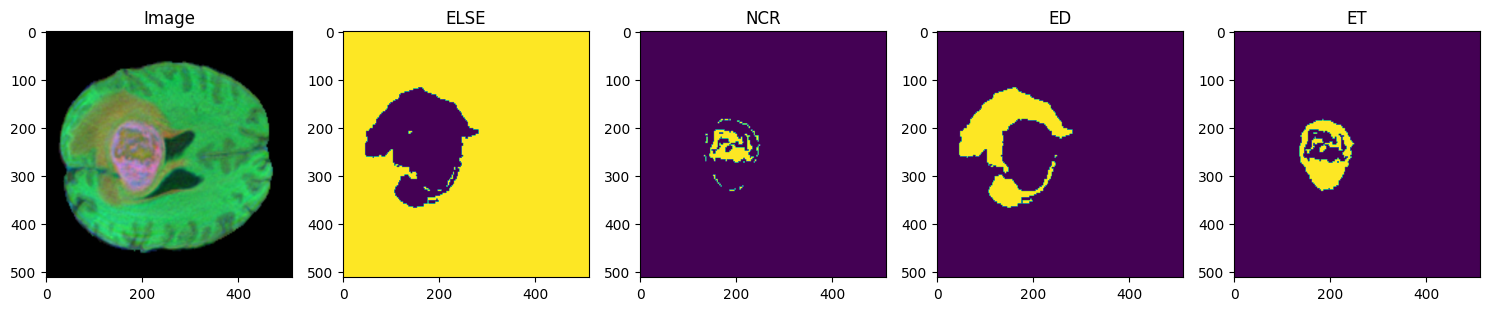

In [85]:
# Visualize input data
true_img = {}

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"Image")

for mask_idx, label in enumerate(test_class_labels):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    label_id = label.item()
    true_img[label_id] = img
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[label_id]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()


In [86]:
# load one batch of data and make predictions

model.to(device)

model.eval()
with torch.no_grad():
    outputs = model(
            pixel_values=test_image.unsqueeze(0).to(device),
            mask_labels=[test_mask_label.to(device)],
            class_labels=[test_class_labels.to(device)],
        )

torch.cuda.empty_cache()

# post-processing of output
target_size = transforms.ToPILImage()(test_image).size[::-1]
# target_size = (163, 193)
results = processor.post_process_instance_segmentation(outputs, target_sizes=[target_size])[0]

print(results['segments_info'])
print(test_image.shape)
print(results['segmentation'].shape)

[{'id': 0, 'label_id': 1, 'was_fused': False, 'score': 0.92309}, {'id': 1, 'label_id': 2, 'was_fused': False, 'score': 0.940313}, {'id': 2, 'label_id': 3, 'was_fused': False, 'score': 0.938796}, {'id': 3, 'label_id': 0, 'was_fused': False, 'score': 0.992247}]
torch.Size([3, 512, 512])
torch.Size([512, 512])


In [87]:
# Obtain labels in true, predict, intersection and union

labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )
# remove duplicates
labels_pred = list(set(labels_pred))

labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'NCR', 'ED', 'ET']
Predicted labels: ['NCR', 'ED', 'ET', 'ELSE']
All labels: ['NCR', 'ED', 'ET', 'ELSE']
Common labels: ['NCR', 'ED', 'ET', 'ELSE']


Visualizing mask for instance: ELSE
label_id is: 0
Visualizing mask for instance: NCR
label_id is: 1
Visualizing mask for instance: ED
label_id is: 2
Visualizing mask for instance: ET
label_id is: 3


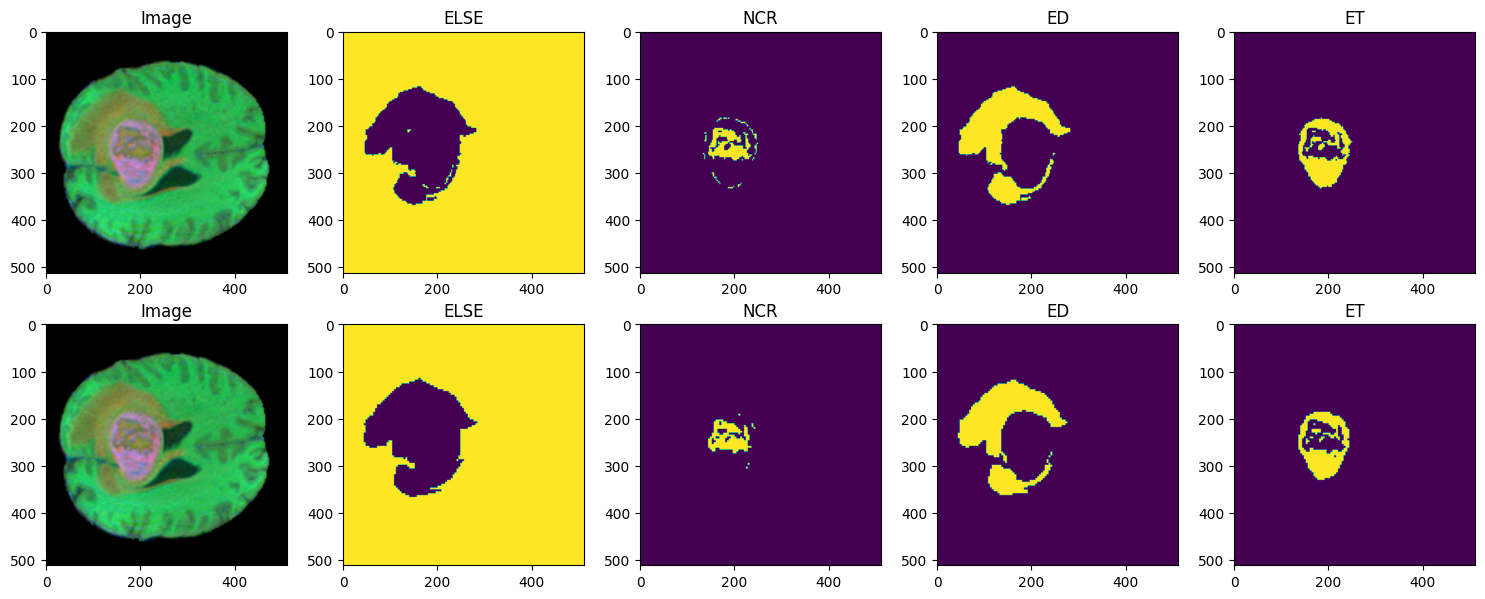

In [88]:
# visual QC predicted masks

n_image = len(id2label)+1
id_list = list(id2label.keys())
id_list.sort()

mask_preds = {}

fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid
mask_pred = np.zeros((len(id_list)))
for mask_idx, id in enumerate(id_list):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[0,mask_idx+1].imshow(img)
    axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

for mask_idx, id in enumerate(id_list):
    mask_pred = np.zeros((results['segmentation'].shape[0],results['segmentation'].shape[1]))

    # find information in results
    for item in results['segments_info']:
        if item['label_id'] == id:
            segment = item
            mask_pred += np.array( get_mask(results['segmentation'], segment['id']) )

    mask_pred = mask_pred.astype(np.uint8)
    mask_preds[id] = mask_pred

    label = id2label[id]
    print("Visualizing mask for instance:", label)
    print("label_id is:", id )

    axs[1,mask_idx+1].imshow(mask_pred)
    axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0,0].imshow(unnormalized_image)
axs[0,0].set_title(f"Image")

axs[1,0].imshow(unnormalized_image)
axs[1,0].set_title(f"Image")

plt.tight_layout()
plt.show()

#### 4.1.2 Visualization of model output (Optional)

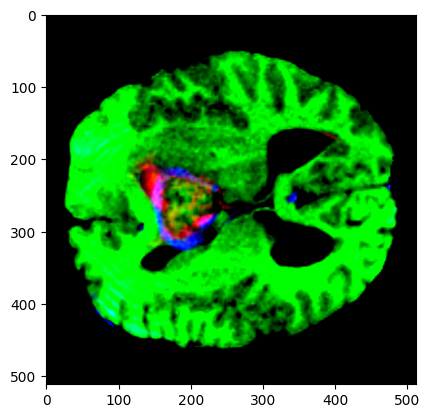

In [ ]:
# display first image

input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([1, 100, 5])
masks_queries_logits shape: torch.Size([1, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([1, 1024, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([1, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([1, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([1, 8, 100, 100])


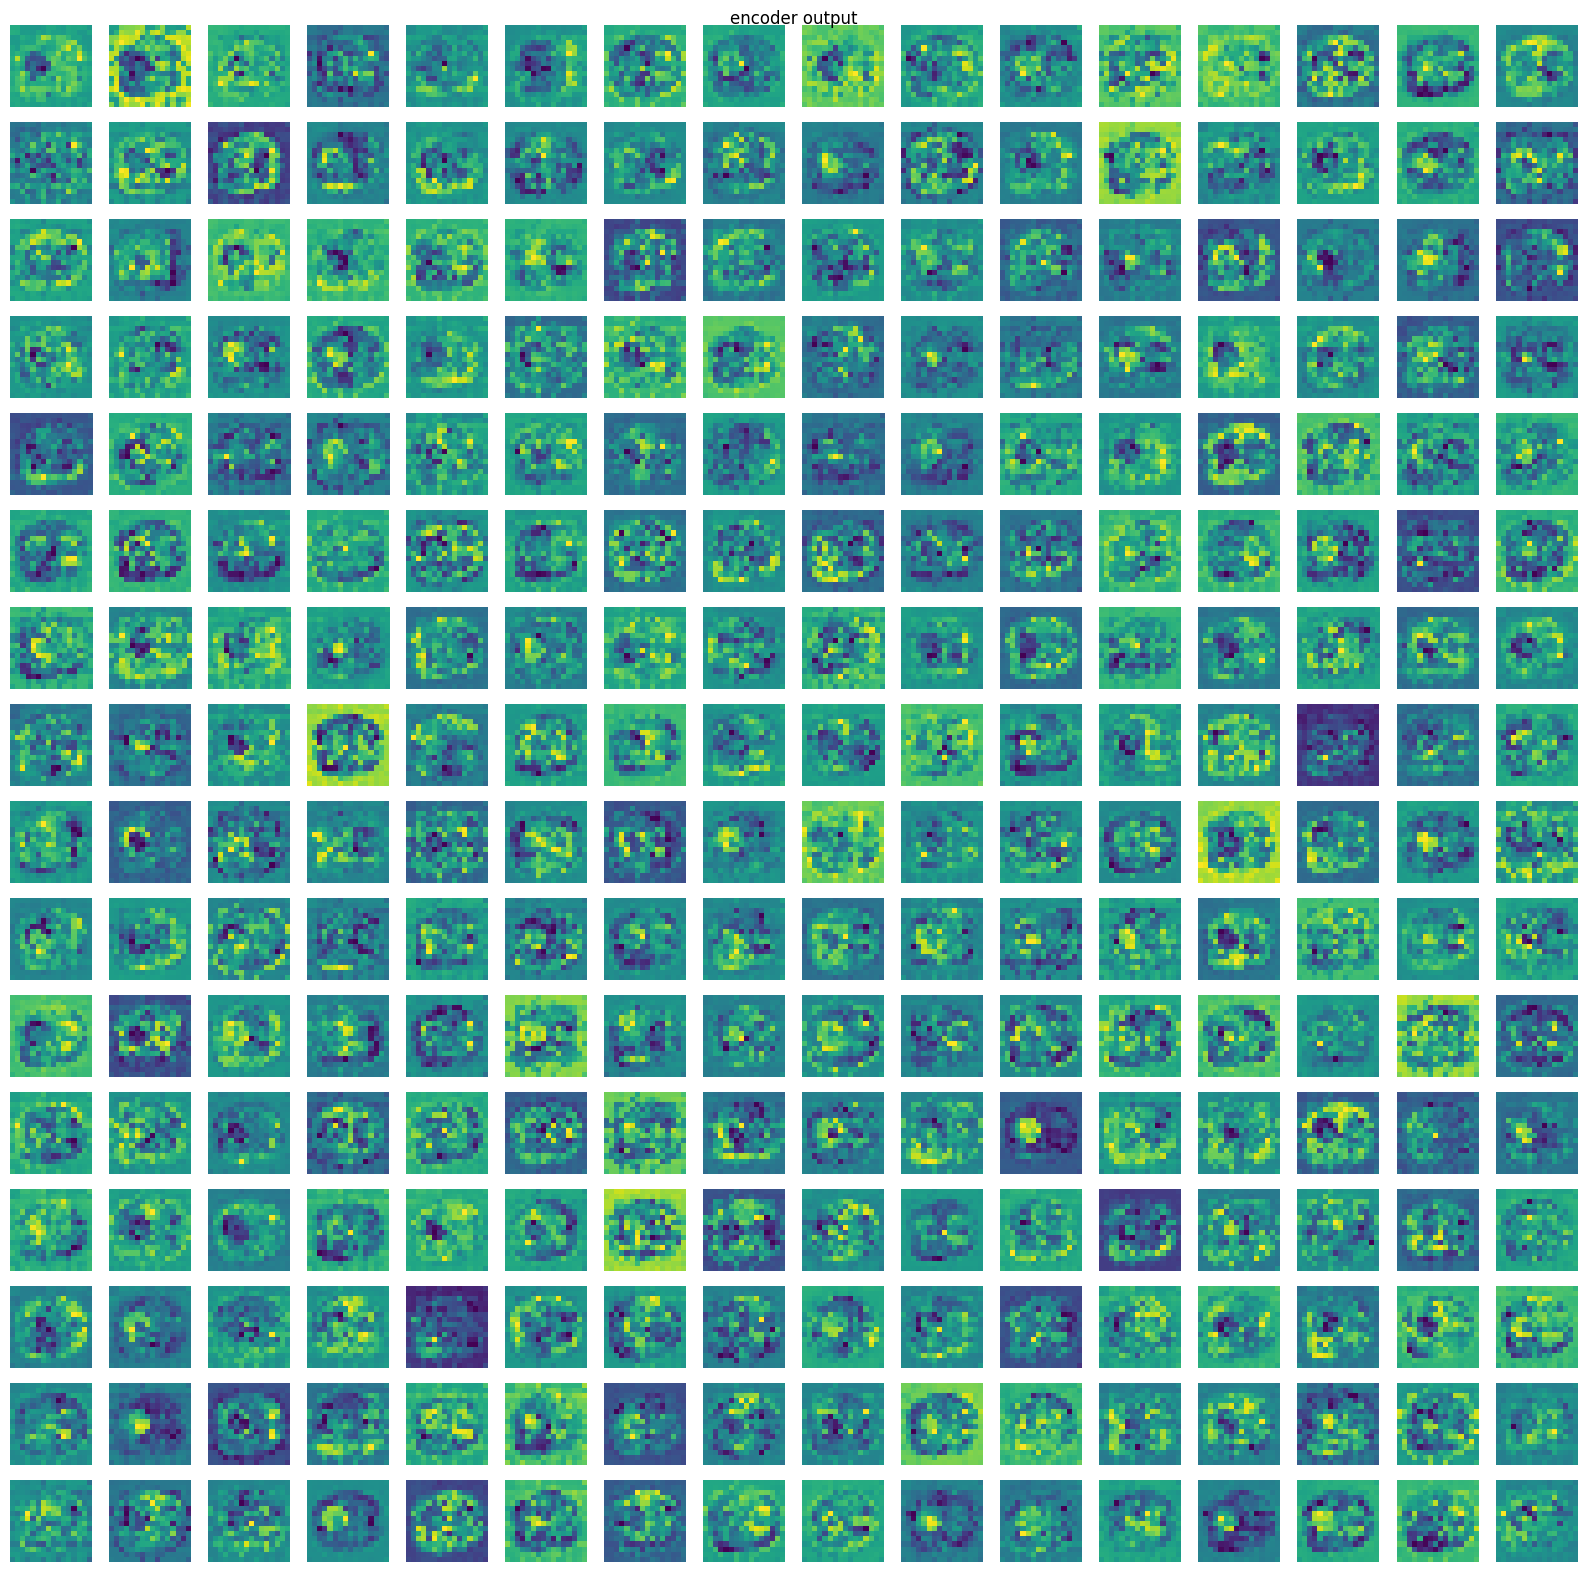

In [ ]:
# visualize the last layer of the encoder

n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

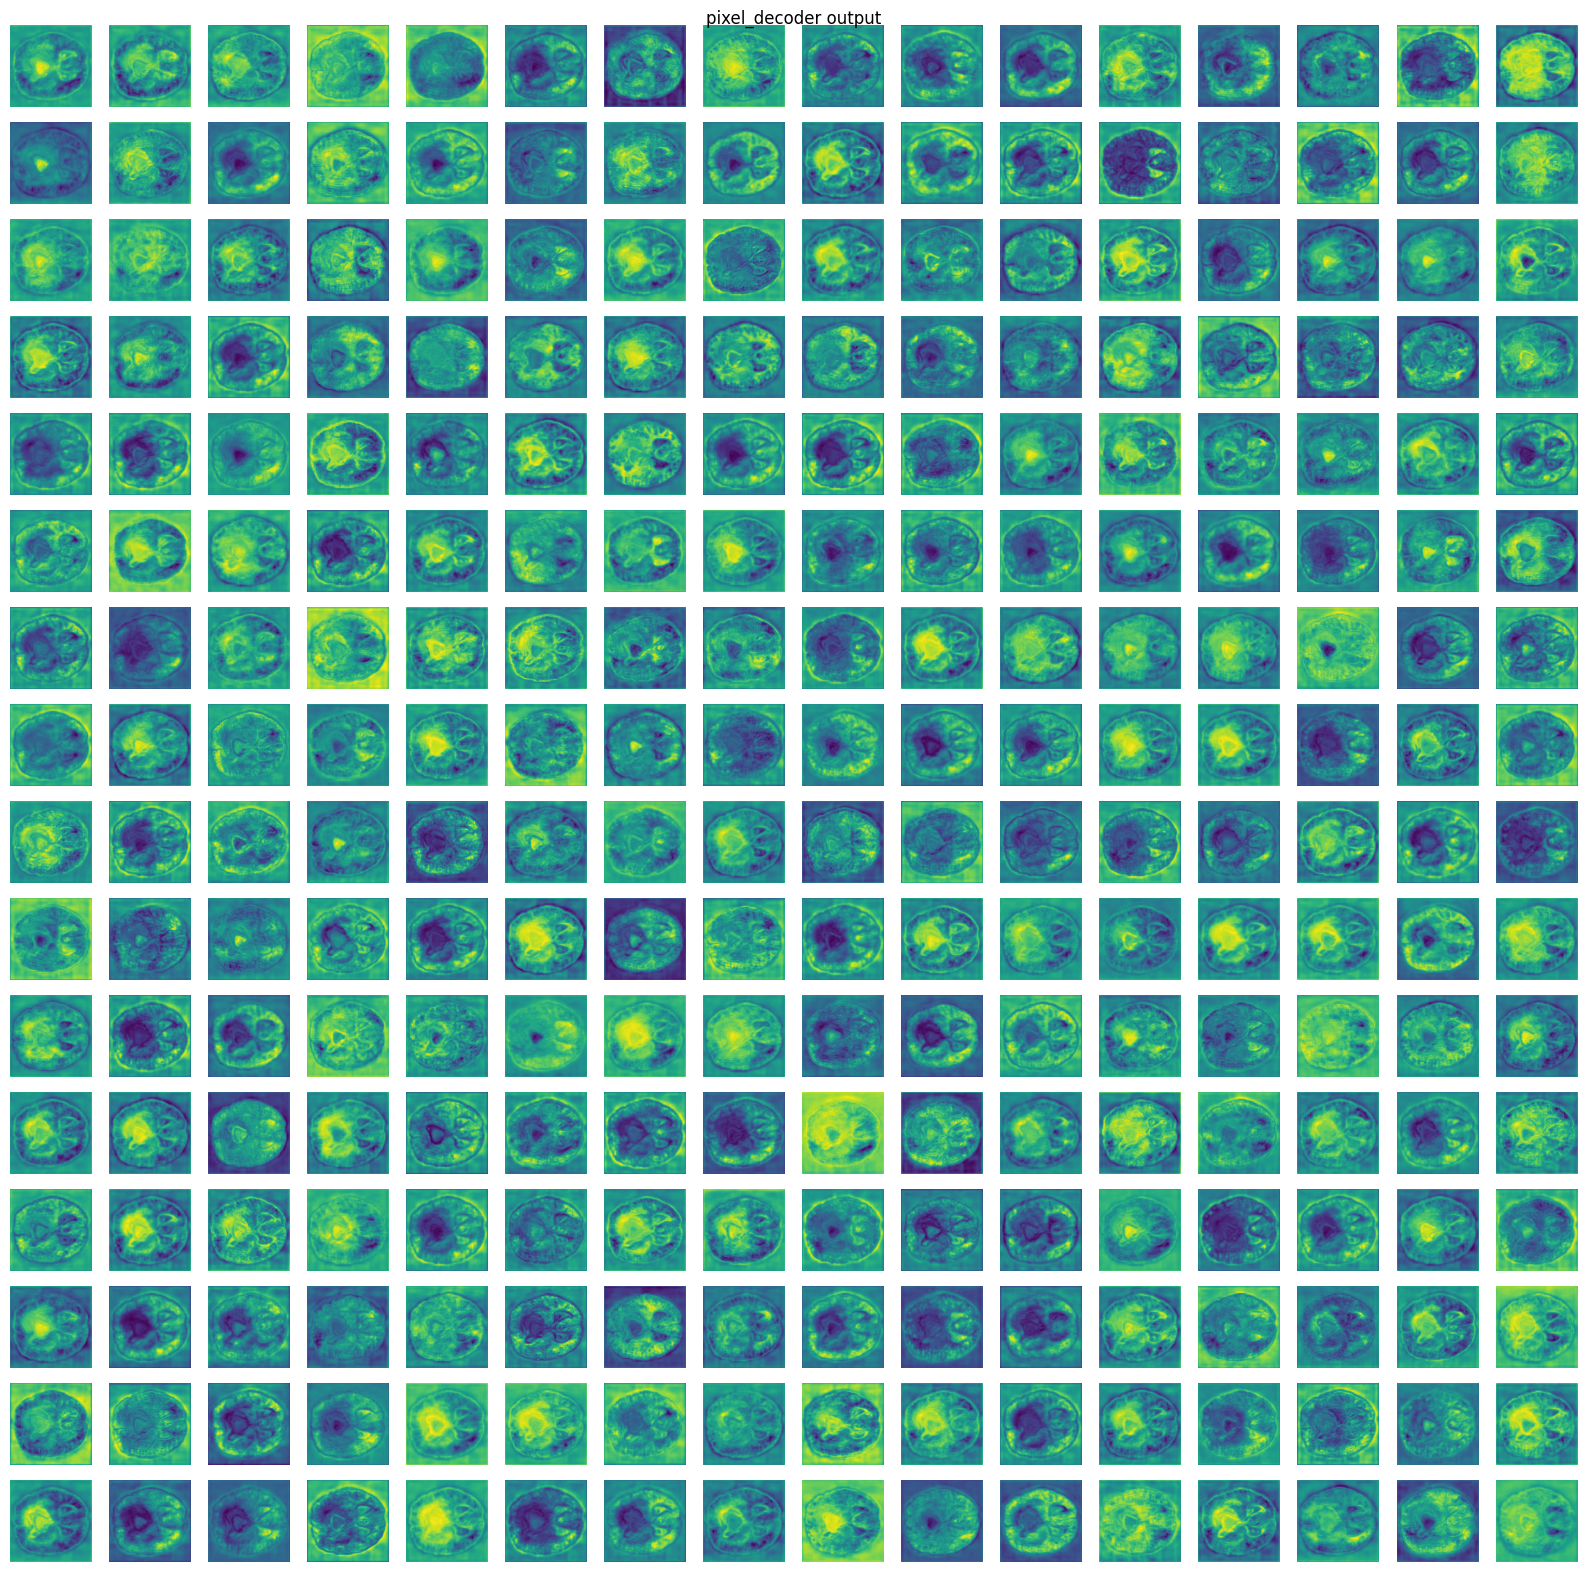

In [ ]:
# visualize the last layer of the pixel decodeer

n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

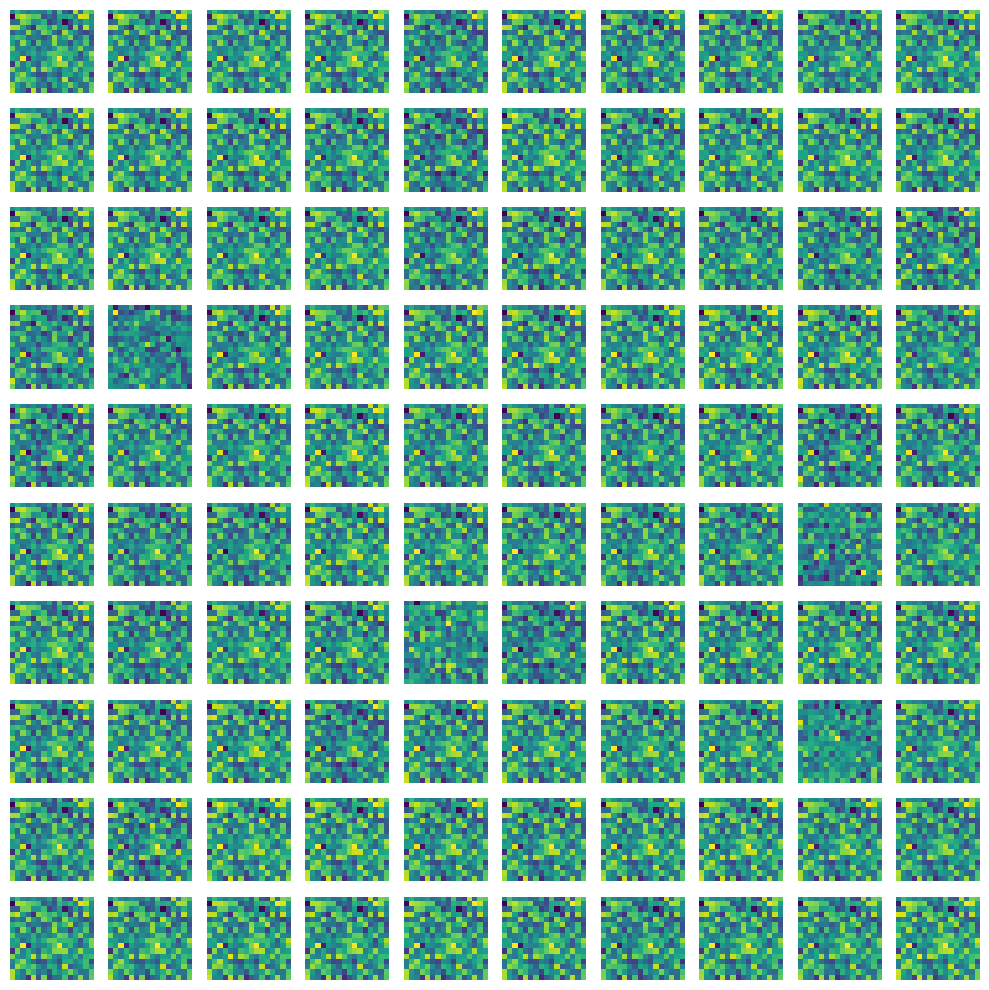

In [ ]:
# visualize the last layer of the transformer decodeer

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        decoder_last_test =  outputs.transformer_decoder_last_hidden_state[0,idx,:].detach().cpu().numpy().reshape((16,16))
        axs[irow,icol].imshow(decoder_last_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

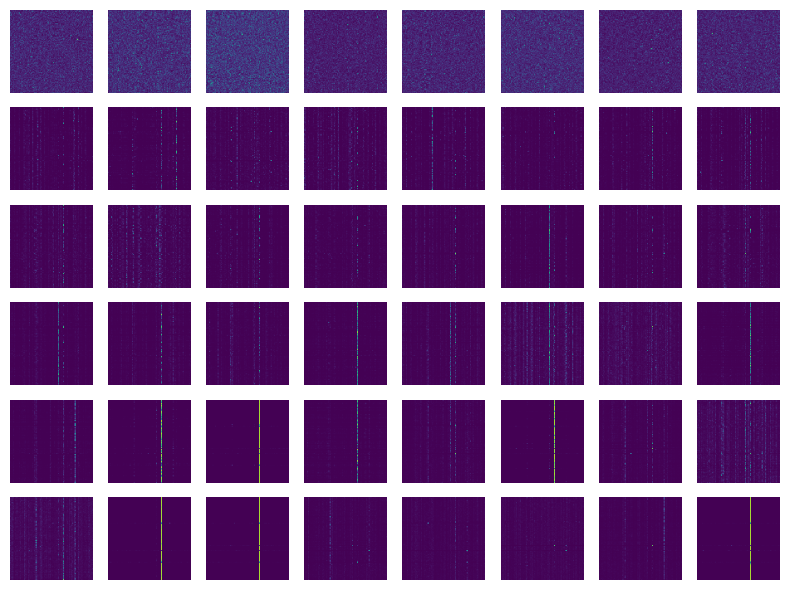

In [ ]:
#visualize the attention map

n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

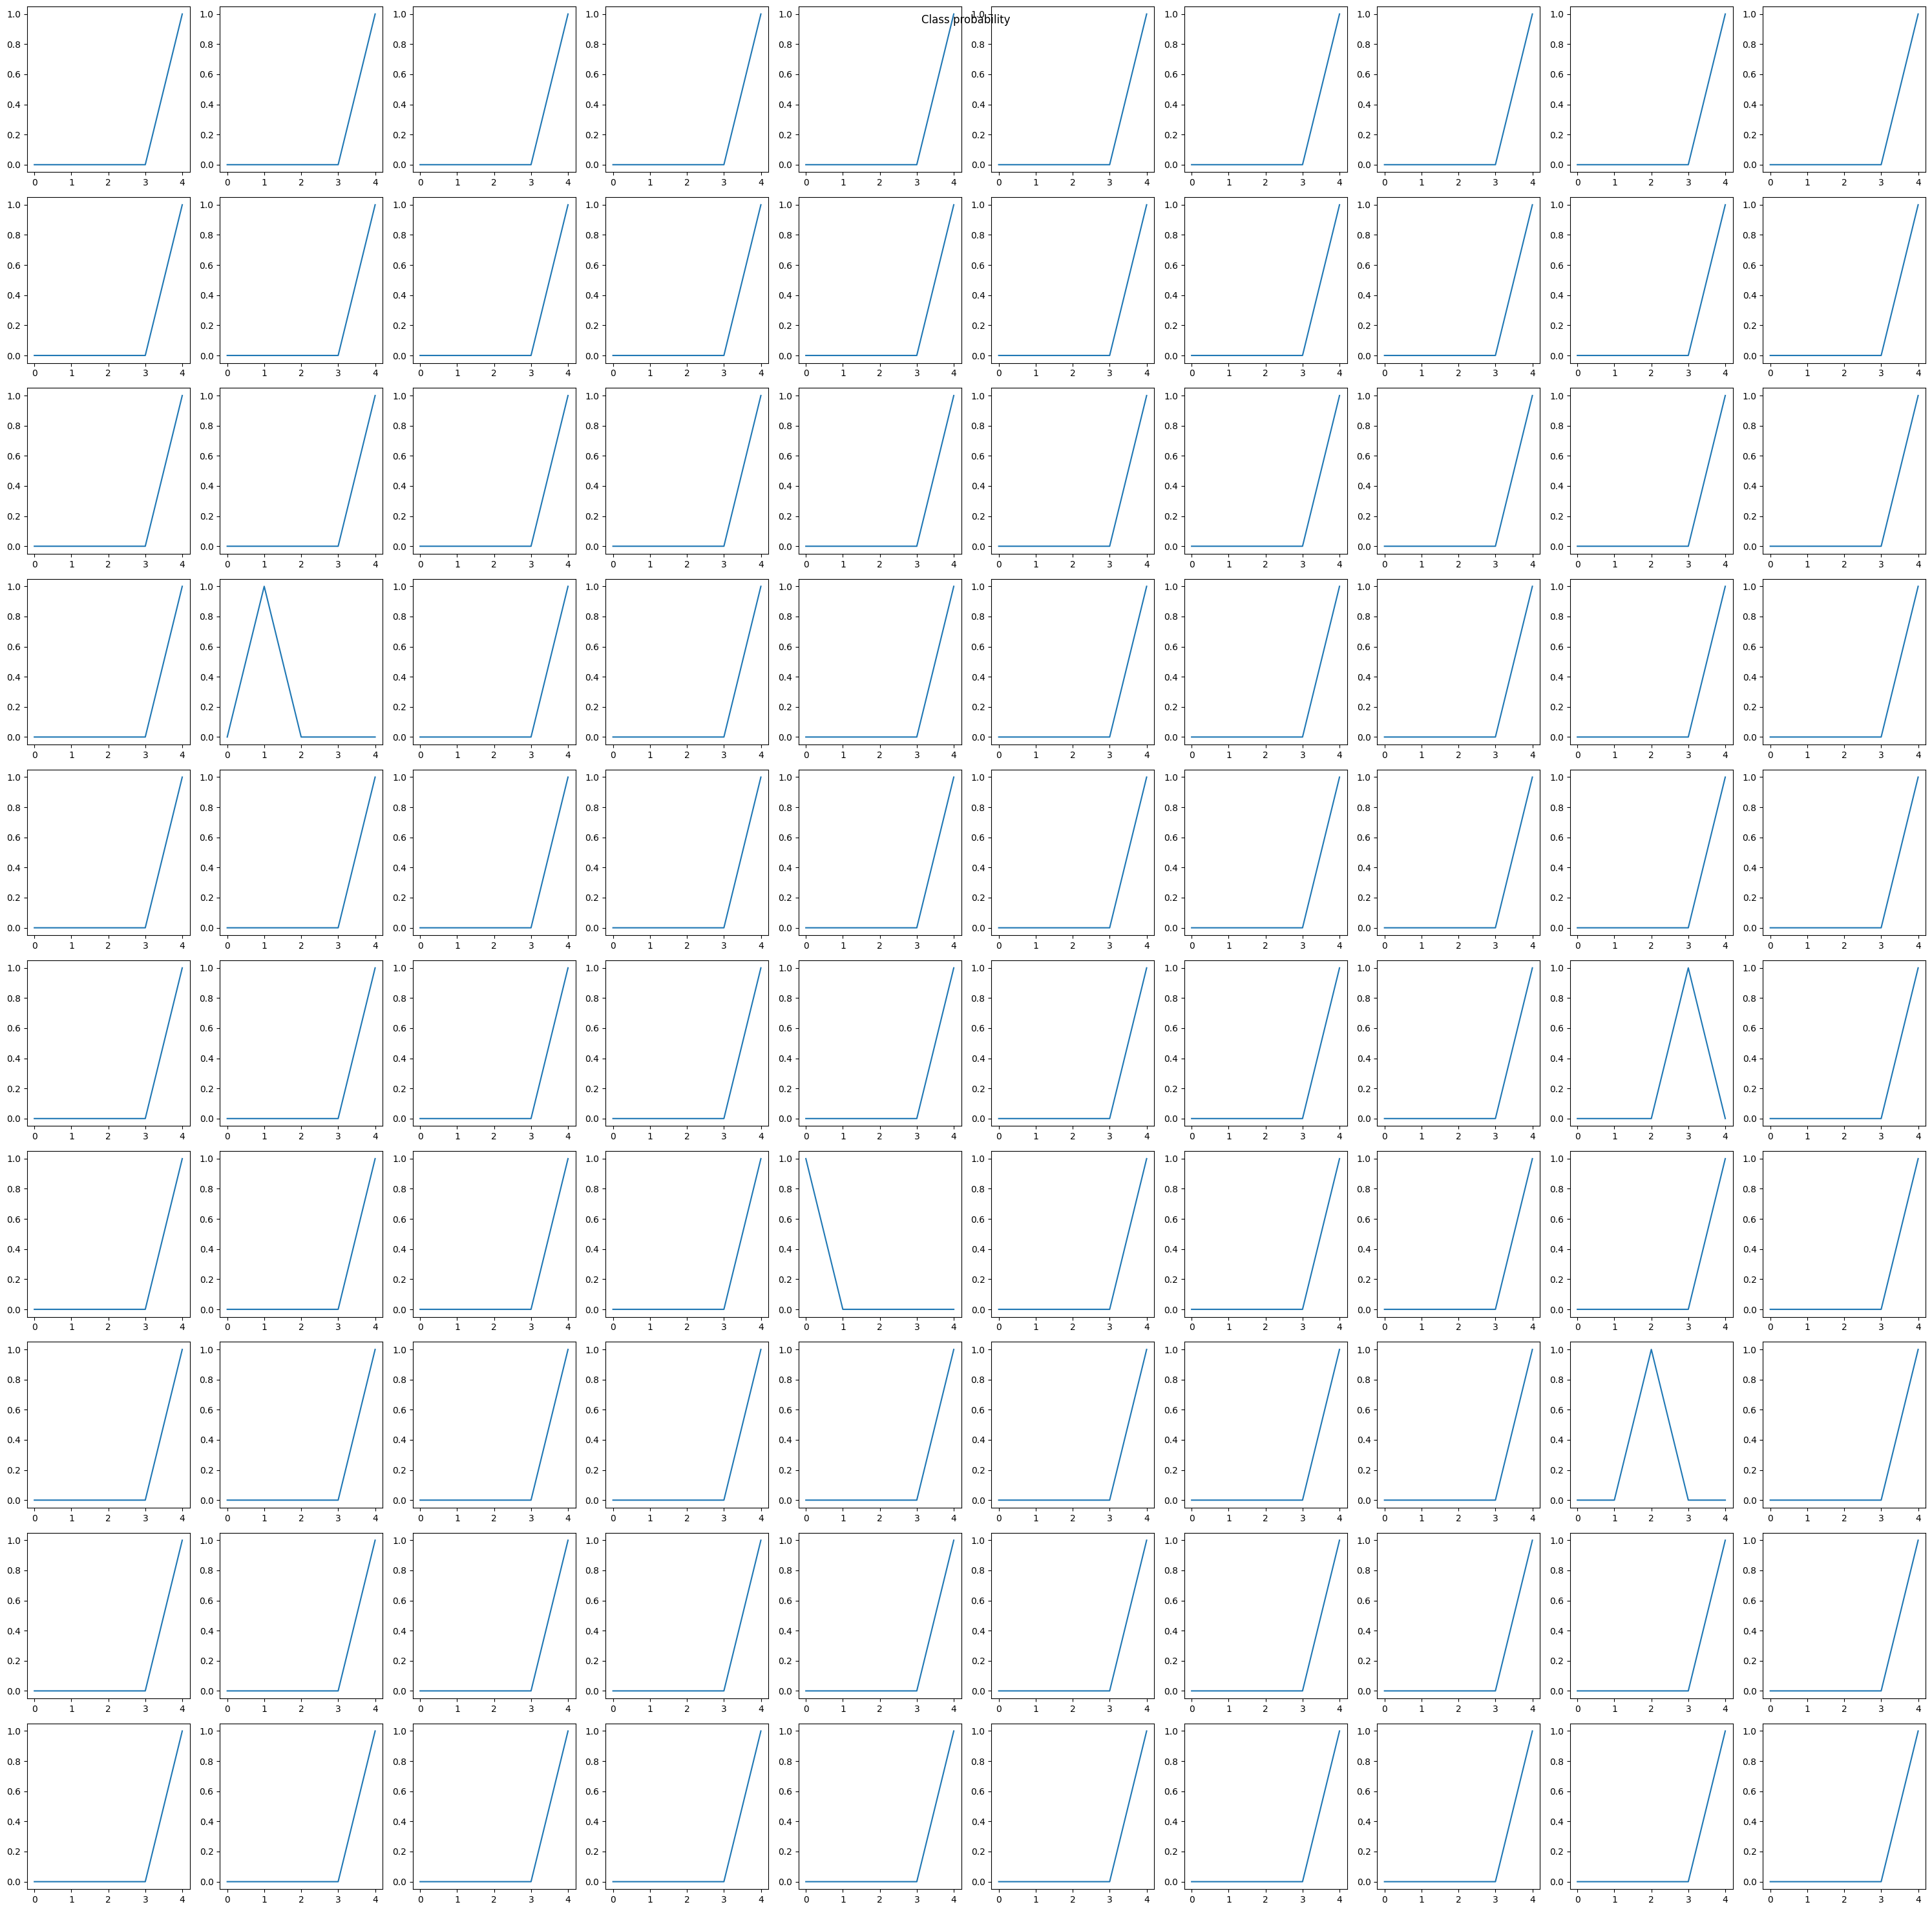

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation

img_size = outputs.pixel_decoder_last_hidden_state.shape[-1]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_size*img_size)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_size, img_size).numpy()

mask_pred_vis.shape

(100, 128, 128)

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

torch.Size([256, 16384])
torch.Size([100, 256])


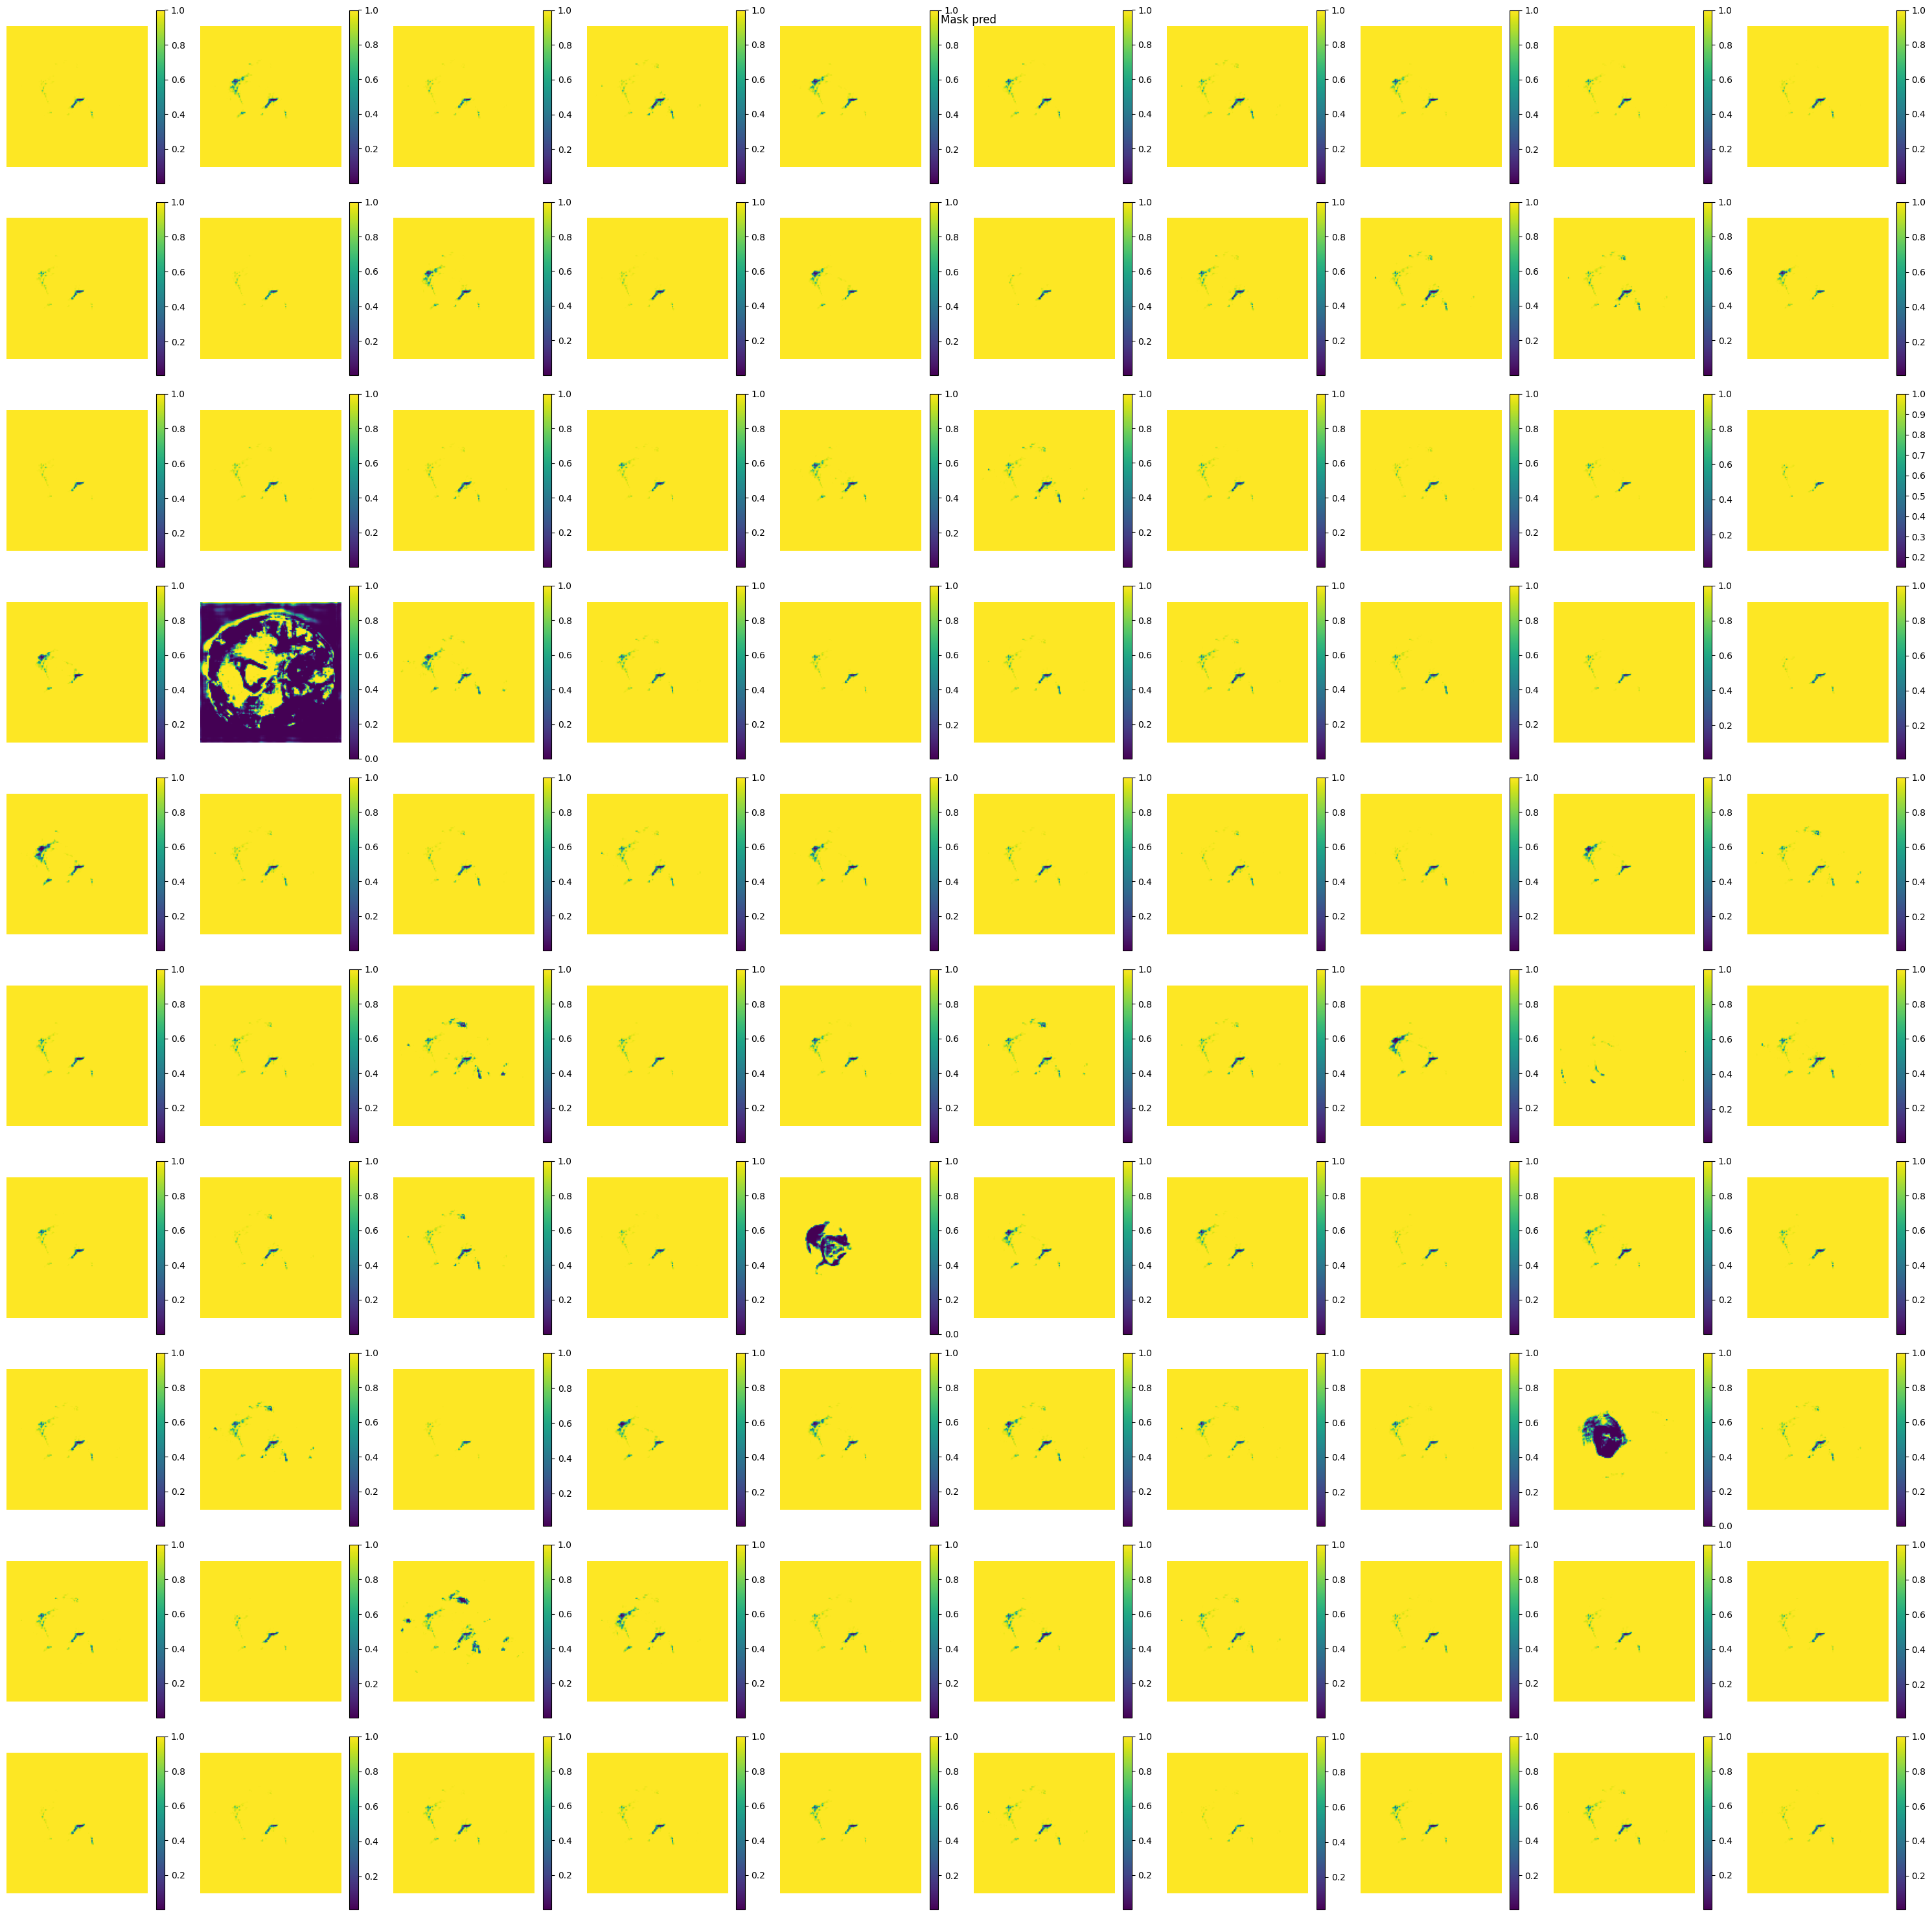

In [ ]:
# visualize mask prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


In [ ]:
print('shape of class probability is:',class_probs.shape)
print('shape of predicted mask is:',mask_pred.shape)

shape of class probability is: (100, 5)
shape of predicted mask is: (512, 512)


torch.Size([128, 128])


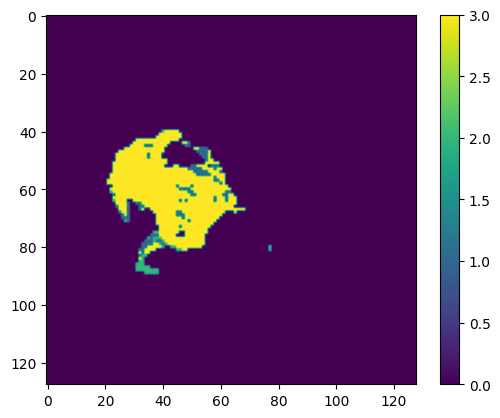

In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_size*img_size)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_size,img_size)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()

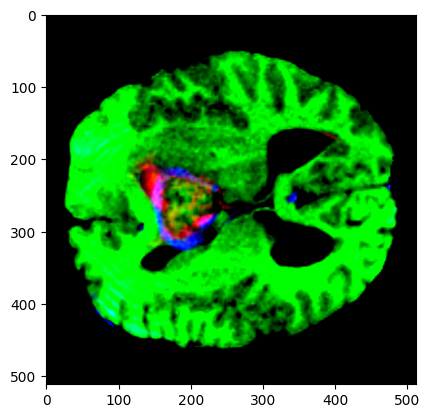

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)

#### 4.1.3 Calcualte metrics on one sample

In [89]:
for label_id, true_mask_pil in true_img.items():
  print(f"Metrics for {id2label[label_id]}:")
  true_mask = (np.array(true_mask_pil)/255).astype(np.uint8)
  if label_id in mask_preds:
    pred_mask_pil = mask_preds[label_id]
    pred_mask = (np.array(pred_mask_pil)/255).astype(np.uint8)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)

    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

  else:
    print(f"Segment {id2label[label_id]} does not exist in prediction")

  print("")
  # calc_binary_metrics(segm_pred, segm_true, segm_id)

Metrics for ELSE:
Specificity 0.9911840660156134
Sensitivity 0.9908953623251844
Precision 0.9986897367120774
Recall 0.9908953623251844
Dice Score 0.994777281945479
HD95 5.0

Metrics for NCR:
Specificity 0.9975692963752665
Sensitivity 0.773724368144969
Precision 0.8380681818181818
Recall 0.773724368144969
Dice Score 0.8046119514009422
HD95 26.590398201248387

Metrics for ED:
Specificity 0.9949853584079239
Sensitivity 0.9458907363420428
Precision 0.9427556818181818
Recall 0.9458907363420428
Dice Score 0.944320607066635
HD95 4.123105625617661

Metrics for ET:
Specificity 0.9981001107611777
Sensitivity 0.8693901716992303
Precision 0.9383946830265849
Recall 0.8693901716992303
Dice Score 0.9025754502427931
HD95 3.0



### 4.2 make predictions on all data and compute metrics

#### 4.2.1 obtain data list for all validation data

In [32]:
val_list_test = data_handler.load_text_as_list(file_name=val_list, train_dir_prefix=train_dir_prefix)
print(val_list_test)

['UPENN-GBM-00008_0.nii.gz', 'UPENN-GBM-00008_1.nii.gz', 'UPENN-GBM-00008_10.nii.gz', 'UPENN-GBM-00008_100.nii.gz', 'UPENN-GBM-00008_101.nii.gz', 'UPENN-GBM-00008_102.nii.gz', 'UPENN-GBM-00008_103.nii.gz', 'UPENN-GBM-00008_104.nii.gz', 'UPENN-GBM-00008_105.nii.gz', 'UPENN-GBM-00008_106.nii.gz', 'UPENN-GBM-00008_107.nii.gz', 'UPENN-GBM-00008_108.nii.gz', 'UPENN-GBM-00008_109.nii.gz', 'UPENN-GBM-00008_11.nii.gz', 'UPENN-GBM-00008_110.nii.gz', 'UPENN-GBM-00008_111.nii.gz', 'UPENN-GBM-00008_112.nii.gz', 'UPENN-GBM-00008_113.nii.gz', 'UPENN-GBM-00008_114.nii.gz', 'UPENN-GBM-00008_115.nii.gz', 'UPENN-GBM-00008_116.nii.gz', 'UPENN-GBM-00008_117.nii.gz', 'UPENN-GBM-00008_118.nii.gz', 'UPENN-GBM-00008_119.nii.gz', 'UPENN-GBM-00008_12.nii.gz', 'UPENN-GBM-00008_120.nii.gz', 'UPENN-GBM-00008_121.nii.gz', 'UPENN-GBM-00008_122.nii.gz', 'UPENN-GBM-00008_123.nii.gz', 'UPENN-GBM-00008_124.nii.gz', 'UPENN-GBM-00008_125.nii.gz', 'UPENN-GBM-00008_126.nii.gz', 'UPENN-GBM-00008_127.nii.gz', 'UPENN-GBM-00008

In [33]:
# create a test volume list
val_vol_list_test = []

sub_string = 'UPENN-GBM-00008'

#
for item in val_list_test:
    if sub_string in item:
        val_vol_list_test.append(item)

# sort the list according to slice number
val_vol_list_test_sorted = sorted(val_vol_list_test, key=lambda x: int(x.split('_')[1].split('.')[0]))
print(val_vol_list_test_sorted)

['UPENN-GBM-00008_0.nii.gz', 'UPENN-GBM-00008_1.nii.gz', 'UPENN-GBM-00008_2.nii.gz', 'UPENN-GBM-00008_3.nii.gz', 'UPENN-GBM-00008_4.nii.gz', 'UPENN-GBM-00008_5.nii.gz', 'UPENN-GBM-00008_6.nii.gz', 'UPENN-GBM-00008_7.nii.gz', 'UPENN-GBM-00008_8.nii.gz', 'UPENN-GBM-00008_9.nii.gz', 'UPENN-GBM-00008_10.nii.gz', 'UPENN-GBM-00008_11.nii.gz', 'UPENN-GBM-00008_12.nii.gz', 'UPENN-GBM-00008_13.nii.gz', 'UPENN-GBM-00008_14.nii.gz', 'UPENN-GBM-00008_15.nii.gz', 'UPENN-GBM-00008_16.nii.gz', 'UPENN-GBM-00008_17.nii.gz', 'UPENN-GBM-00008_18.nii.gz', 'UPENN-GBM-00008_19.nii.gz', 'UPENN-GBM-00008_20.nii.gz', 'UPENN-GBM-00008_21.nii.gz', 'UPENN-GBM-00008_22.nii.gz', 'UPENN-GBM-00008_23.nii.gz', 'UPENN-GBM-00008_24.nii.gz', 'UPENN-GBM-00008_25.nii.gz', 'UPENN-GBM-00008_26.nii.gz', 'UPENN-GBM-00008_27.nii.gz', 'UPENN-GBM-00008_28.nii.gz', 'UPENN-GBM-00008_29.nii.gz', 'UPENN-GBM-00008_30.nii.gz', 'UPENN-GBM-00008_31.nii.gz', 'UPENN-GBM-00008_32.nii.gz', 'UPENN-GBM-00008_33.nii.gz', 'UPENN-GBM-00008_34.nii

In [34]:

# a list of list of file names
val_vol_list = []
val_vol_list.append(val_vol_list_test_sorted)

# obtain list of data.txt files
data_vols_list = []

# save data files
for idx, item in enumerate(val_vol_list):
    list_name = 'val2d_vol_' + str(idx) + '.txt'
    data_file_list_cur = item
    data_handler.save_text(file_name = list_name,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in data_file_list_cur))
    data_vols_list.append(list_name)

In [68]:
# verify data list
print(data_vols_list)
tmp_list = data_handler.load_text_as_list(file_name=data_vols_list[0], train_dir_prefix=train_dir_prefix)
print(tmp_list)

['val2d_vol_0.txt']
['UPENN-GBM-00008_0.nii.gz', 'UPENN-GBM-00008_1.nii.gz', 'UPENN-GBM-00008_2.nii.gz', 'UPENN-GBM-00008_3.nii.gz', 'UPENN-GBM-00008_4.nii.gz', 'UPENN-GBM-00008_5.nii.gz', 'UPENN-GBM-00008_6.nii.gz', 'UPENN-GBM-00008_7.nii.gz', 'UPENN-GBM-00008_8.nii.gz', 'UPENN-GBM-00008_9.nii.gz', 'UPENN-GBM-00008_10.nii.gz', 'UPENN-GBM-00008_11.nii.gz', 'UPENN-GBM-00008_12.nii.gz', 'UPENN-GBM-00008_13.nii.gz', 'UPENN-GBM-00008_14.nii.gz', 'UPENN-GBM-00008_15.nii.gz', 'UPENN-GBM-00008_16.nii.gz', 'UPENN-GBM-00008_17.nii.gz', 'UPENN-GBM-00008_18.nii.gz', 'UPENN-GBM-00008_19.nii.gz', 'UPENN-GBM-00008_20.nii.gz', 'UPENN-GBM-00008_21.nii.gz', 'UPENN-GBM-00008_22.nii.gz', 'UPENN-GBM-00008_23.nii.gz', 'UPENN-GBM-00008_24.nii.gz', 'UPENN-GBM-00008_25.nii.gz', 'UPENN-GBM-00008_26.nii.gz', 'UPENN-GBM-00008_27.nii.gz', 'UPENN-GBM-00008_28.nii.gz', 'UPENN-GBM-00008_29.nii.gz', 'UPENN-GBM-00008_30.nii.gz', 'UPENN-GBM-00008_31.nii.gz', 'UPENN-GBM-00008_32.nii.gz', 'UPENN-GBM-00008_33.nii.gz', 'UP

#### 4.2.2. make predictions on all validation data

In [ ]:

# id_list is always the same for given project
id_list = list(id2label.keys())

mask_pred_3d = np.zeros((len(id_list), 146, 512, 512), dtype=np.uint8)
image_3d = np.zeros((146, 3, 512, 512), dtype=np.uint8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for data_file in data_vols_list:
    # define a new dataset
    val_metric_dataset = CustomMRIDataset(data_handler=data_handler, dataset_type=MriType.VAL_2D,
                                          data_list_fn=data_file, processor=processor,
                                          transform=train_transform, augment=False)
    batch_size_metrics = 1
    # define data loader
    val_metric_dataloader = DataLoader(val_metric_dataset, batch_size=batch_size_metrics,
                                       shuffle=False, collate_fn=collate_fn)

    # make predictions on all 2D slices of current volume
    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(val_metric_dataloader):
            # Forward pass
            output_cur = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # post-processing of output
            image_cur = batch["pixel_values"][0]
            image_3d[ibatch, :, :, :] = image_cur
            result_cur = processor.post_process_instance_segmentation(output_cur, target_sizes=[transforms.ToPILImage()(image_cur).size[::-1]])[0]

            # obtain predicted_mask
            for mask_idx, id in enumerate(id_list):
                mask_pred_cur = np.zeros((result_cur['segmentation'].shape[0], result_cur['segmentation'].shape[1]))

                # find predcited masks in results
                for item in result_cur['segments_info']:
                    if item['label_id'] == id:
                        segment = item
                        mask_pred_cur += np.array( get_mask(results['segmentation'], segment['id']) )

                mask_pred_cur = mask_pred_cur.astype(np.uint8)
                mask_pred_3d[mask_idx, ibatch, :, :] = mask_pred_cur

            # metric apply to all classes


In [60]:
result_cur['segments_info']

[]

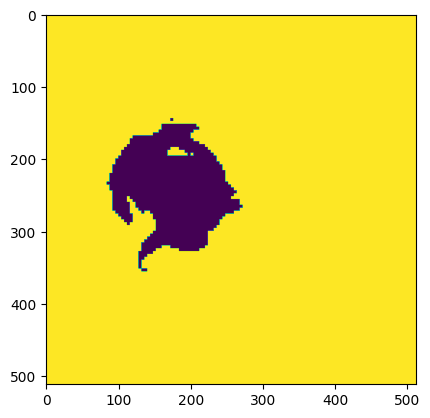

In [90]:
plt.imshow(mask_pred_3d[0,100,:,:])

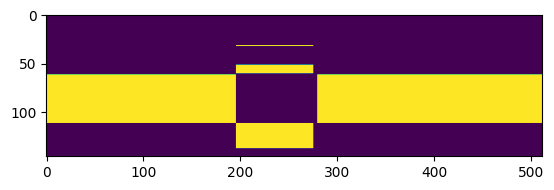

In [91]:
plt.imshow(mask_pred_3d[0,:,:,100])

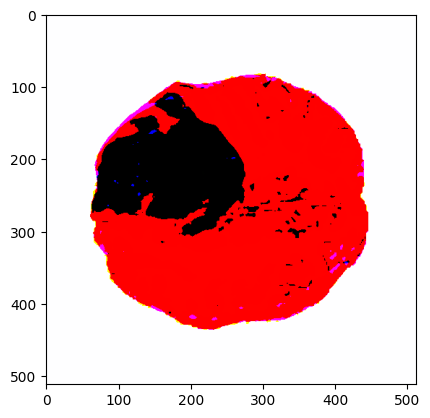

In [56]:
plt.imshow(np.moveaxis(image_3d[110,:,:,:], 0, 2))

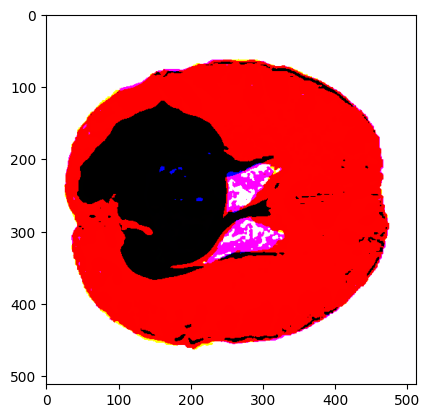

In [74]:
plt.imshow(np.moveaxis(image_3d[90,:,:,:], 0, 2))

In [86]:
len(val_metric_dataloader)

146

## Back-up